<a href="https://colab.research.google.com/github/LiLAlien28/Arch_Tech_internship/blob/main/Task1_Email_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Download NLTK stopwords
nltk.download('stopwords')

print("All libraries imported successfully!")

All libraries imported successfully!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Load the dataset from URL
url = "https://raw.githubusercontent.com/justmarkham/pydata-dc-2016-tutorial/master/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset shape: (5572, 2)

First 5 rows:


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Missing values:
label      0
message    0
dtype: int64

Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


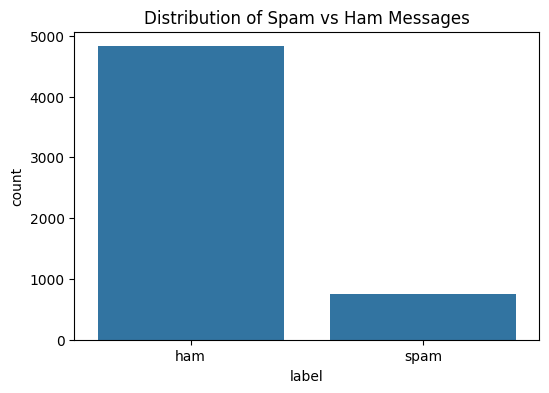

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [3]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check the distribution of labels
print("\nLabel distribution:")
print(df['label'].value_counts())

# Visualize the distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label')
plt.title('Distribution of Spam vs Ham Messages')
plt.show()

# Convert labels to binary (ham=0, spam=1) for modeling
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

# Check the first few rows again to confirm
df.head()